XRF quantification
========
The fluorescence/scattered intensity $I_{i,j}$ due to irradiation with flux $I_s$

$$
\begin{equation}
I_{i,j}=I_s(Hz)\Delta t(s)\Omega(sr)\epsilon_{i,j} c_{i,j}(sr^{-1})
\end{equation}
$$

where $I_{i,j}$ the fluorescence/scattered intensity with energy $E_{j}$ due to incident photons with energy $E_{i}$, $\Delta t$ the exposure time, $\Omega$ the solid angle of the detector, $\epsilon_{i,j}$ a product of filter transmission and detector absorbance and $c_{i,j}$ the rate of line $j$ due to source line $i$ (depending on sample composition).

As an example, the fluorescence rate of a flat-multilayer sample can be written as (only primary fluorescence)

$$
\begin{equation}
c_{i,j}(sr^{-1})=\frac{\mu_j}{4\pi}\sum_k w_{j,k}\rho_k t_k^\prime(E_i,E_j)
\end{equation}
$$

where $k$ loops over the layers and $t_k^\prime$ is a corrected layer thickness (takes self-absorption into account). For a single layer in reflection geometry this becomes

$$
\begin{equation}
\begin{split}
t^\prime(E_i,E_j) =& \frac{e^{\chi(E_i,E_j) t}-1}{\chi(E_i,E_j)\cos\alpha_{in}}\\
\chi(E_i,E_j) =& \rho\left(\frac{\mu(E_j)}{\cos\alpha_{out}}-\frac{\mu(E_i)}{\cos\alpha_{in}}\right)
\end{split}
\end{equation}
$$

where $\alpha$ the angle between the sample surface normal (pointing away from the source) and the incident(in) or fluorescence(out) direction ($\alpha_{out}>90^\circ$ in reflection geometry). Note that $\lim_{\chi\to\infty}t^\prime=\frac{t}{\cos\alpha_{in}}$.

## Geometry calibration

### Solid-angle parameterization (without standard)
See the notebook on [diodes](diodes.ipynb) on how $I_s$ is measured. We will assume the detector has a centric-cone geometry with solid angle

$$
\begin{equation}
\Omega=2\pi\left(1-\frac{x+d_0}{\sqrt{\frac{A}{\pi}+\left(x+d_0\right)^2}}\right)
\end{equation}
$$

where $A(mm^2)$ the active area of the detector, $x(mm)$ the position of the detector and $d_0(mm)$ the distance to the sample for $x=0$. To determine $A$ and $d_0$ we can measure the fluorescence of any sample as function of $x$:

$$
\begin{equation}
I(x,c,d_0,A)=c\Omega(x,d_0,A)
\end{equation}
$$

As an illustration we will define a detector geometry and multilayer sample. A thin-film standard is used here but any other material can be considered:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

from spectrocrunch.materials import xrfstandards
from spectrocrunch.detectors import xrf as xrfdetectors
from spectrocrunch.geometries import xrf as xrfgeometries
from spectrocrunch.sources import xray as xraysources

source = xraysources.factory("synchrotron")
detector = xrfdetectors.factory("leia")
geometry = xrfgeometries.factory("sxm120",detectorposition=-10,positionunits="mm",\
                                 detector=detector,source=source)

addnoise = True # add noise to simulations done below
method = "fisx" # XRF simulation method

sample = xrfstandards.factory("RF7-200-S2371-03",geometry=geometry,\
                                             filmthickness=10e-7) # 10 nm
print(sample)

Multilayer (ordered top-bottom):
 Layer 0. 0.01 um (RF7-200-S2371-03)
 Layer 1. 0.2 um (silicon nitride)


Simulate a detector scan $I(x,c,d_0,A)$:


Theoretical geometry:
 Zero-distance: 5.0 cm
 Active area: 70.0 mm ** 2


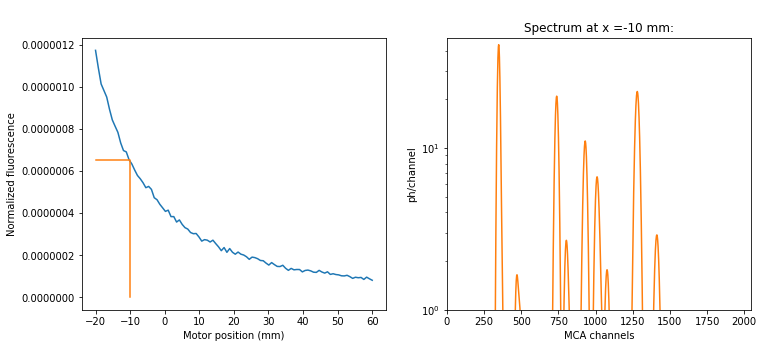

In [2]:
from spectrocrunch.common import units
from spectrocrunch.math import noisepropagation
from spectrocrunch.materials import pymca

# Geometry at which the data is collected
geometry.zerodistance = units.Quantity(5.,"cm")
detector.activearea = units.Quantity(70.,"mm^2")
print("\nTheoretical geometry:")
print(" Zero-distance: {:~}".format(geometry.zerodistance.to("cm")))
print(" Active area: {:~}".format(detector.activearea.to("mm^2")))

# Simulate measurement at current distance
energy = 7.3
flux = 1e9
time = 5
pymcahandle = pymca.PymcaHandle(sample=sample,energy=energy,flux=flux,time=time,\
                                linear=True,escape=False,continuum=False,scatter=False)
mcaref = pymcahandle.mca(histogram=True,scattering=False,method=method)

# Simulate detector scan
n = 100
x = units.Quantity(np.linspace(-20,60,n),"mm")
I0  = np.full(n,flux*time)
solidangle = geometry.detector.solidangle_calc(activearea=detector.activearea,distance=x+geometry.zerodistance)
fluo = mcaref.sum()/geometry.solidangle*solidangle

if addnoise:
    I0 = np.random.poisson(np.round(I0).astype(int))
    fluo = np.random.poisson(np.round(fluo).astype(int))

fig,axs = plt.subplots(1,2,figsize=(12,5))

u = x.units
plt.sca(axs[0])
plt.plot(x,fluo/I0.astype(float))
xref = geometry.detectorposition.to(u).magnitude
iref = mcaref.sum()/(flux*time)
lines = plt.plot([xref,xref,x[0].magnitude],[0,iref,iref])
color = lines[0].get_color()
plt.ylabel("Normalized fluorescence")
plt.xlabel("Motor position ({:~})".format(u))

plt.sca(axs[1])
plt.plot(mcaref,color=color)
plt.gca().set_yscale('log', basey=10)
plt.xlim([0,len(mcaref)-1])
plt.ylim([1,np.max(mcaref)*1.1])
plt.ylabel("ph/channel")
plt.xlabel("MCA channels")
plt.title("\nSpectrum at x ={:~}:".format(geometry.detectorposition.to("mm")))
plt.show()

Calibrate the geometry (starting from different values as the ones used to simulate the data):


Initial geometry:
Zero-distance: 11.0 cm
Active area: 60.000000 mm ** 2


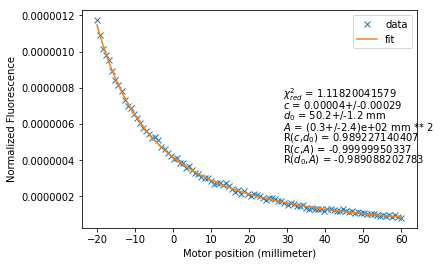

Calibrated geometry:
Zero-distance: 5.02+/-0.12 cm
Active area: 30+/-237 mm ** 2


In [3]:
# Calibration resources
fluo = noisepropagation.poisson(fluo)
I0 = noisepropagation.poisson(I0)
intensities = fluo/I0

calibrc = {"signal":noisepropagation.E(intensities),\
            "var":noisepropagation.VAR(intensities),\
            "detectorposition":x.magnitude,\
            "positionunits":x.units}

# Calibrate the geometry (starting from wrong values)
geometry.zerodistance += units.Quantity(6.,"cm")
detector.activearea += units.Quantity(-10.,"mm^2")

print("\nInitial geometry:")
print("Zero-distance: {:~}".format(geometry.zerodistance.to("cm")))
print("Active area: {:f~}".format(detector.activearea.to("mm^2")))

geometry.calibrate(calibrc=calibrc,plot=True,fit=True,fixedactivearea=False)
plt.show()

print("Calibrated geometry:")
print("Zero-distance: {:~}".format(geometry.zerodistance_rv.to("cm")))
print("Active area: {:f~}".format(detector.activearea_rv.to("mm^2")))

The correlation between $c$, $A$ and $d_0$ is too high to provide a usable result (also when fixing the active area).

### Solid-angle parameterization (with standard)

To solve the correlation issue, we determine $\Omega_{ref}$ at a particular motor position $x=x_{ref}$ by fitting the fluorescence spectrum of a standard measured with the detector at this position:

$$
\begin{equation}
\begin{split}
I_{i,j}=&I_s(Hz)\Delta t(s)\Omega_{fit}(sr)\epsilon_{i,j} c_{i,j}^{fit}(sr^{-1})\\
=&I_s(Hz)\Delta t(s)\Omega_{ref}(sr)\epsilon_{i,j} c_{i,j}^{ref}(sr^{-1})\\
\Omega_{ref}=&\Omega_{fit}\frac{c_{i,j}^{fit}}{c_{i,j}^{ref}}
\end{split}
\end{equation}
$$

where $I_s$, $\Delta t$ and $\epsilon_{i,j}$ are assumed to be known and $c_{i,j}^{ref}$ is calculated from a known sample composition.

This provides a fixed relationship between $A$ and $d_0$ which can be substituted in the expression used for calibrating the geometry

$$
\begin{equation}
\begin{split}
I(x,c,d_0)=&c\Omega(x,d_0,A(d_0))\\
A(d_0)=&\pi\left(\frac{\left(x_{ref}+d_0\right)^2}{\left(1-\frac{\Omega_{ref}}{2\pi}\right)^2}-\left(x_{ref}+d_0\right)^2\right)
\end{split}
\end{equation}
$$

When using a thin-film standard, the thickness and density of the film are unknown but the areal densities of the elements in the film are known. When assuming self-absorption and secondary effects are negligible we can write

$$
\begin{equation}
\begin{split}
c_{i,j}^{film}=&\frac{\mu_j}{4\pi} w_{j}\rho t=\frac{\mu_j}{4\pi}\rho_{j,A}\\
\Omega_{ref}=&\Omega_{fit}\frac{w_{j}^{fit}}{w_{j}^{ref}}=\Omega_{fit}\frac{\rho_{j,A}^{fit}}{\rho_{j,A}^{ref}}
\end{split}
\end{equation}
$$

For elements in the thin-film you can use either the mass fractions (who's absolute value are meaningless because $\rho$ and $t$ have arbitrary values) or the areal densities to calculate $\Omega_{ref}$. For elements in the substrate however self-absorption may be non-negligible, in which case the mass fractions (who's absolute values are meaningful when $\rho$ and $t$ are known) must be used because:

$$
\begin{equation}
c_{i,j}^{substrate}=\frac{\mu_j}{4\pi} w_{j}\rho t'(E_i,E_j)\neq\frac{\mu_j}{4\pi}\rho_{j,A}
\end{equation}
$$

Simulate and fit an XRF spectrum of a thin-film standard (simulation and fit are done with a different $d_0$ and $A$; scattering, escape and sum peaks are omitted):


Theoretical geometry:
 Zero-distance: 5.0 cm
 Active area: 70.0 mm ** 2

Fitted vs. theory (before geometry calibration):
 Mass fractions and areal densities (within one layer):
 La: 140.40 wt%     (expected:  24.13 wt%,     error: 481.90%)
 La:  52.37 ng/mm^2 (expected:   9.00 ng/mm^2, error: 481.90%)
 Mo:  13.67 wt%     (expected:   2.41 wt%,     error: 466.51%)
 Mo:   5.10 ng/mm^2 (expected:   0.90 ng/mm^2, error: 466.51%)
 Pb: 119.98 wt%     (expected:  20.64 wt%,     error: 481.19%)
 Pb:  44.75 ng/mm^2 (expected:   7.70 ng/mm^2, error: 481.19%)
 Si: 351.50 wt%     (expected:  60.06 wt%,     error: 485.25%)
 Si: 2418.32 ng/mm^2 (expected: 413.21 ng/mm^2, error: 485.25%)
 Fe:  62.64 wt%     (expected:  10.72 wt%,     error: 484.09%)
 Fe:  23.36 ng/mm^2 (expected:   4.00 ng/mm^2, error: 484.09%)
 Pd:  28.75 wt%     (expected:   5.09 wt%,     error: 464.44%)
 Pd:  10.72 ng/mm^2 (expected:   1.90 ng/mm^2, error: 464.44%)
 Ca: 178.12 wt%     (expected:  30.56 wt%,     error: 482.80%)
 

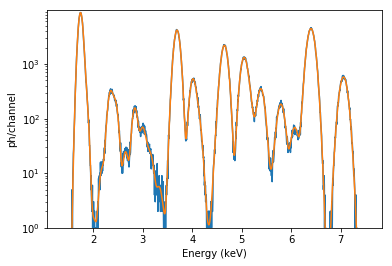

In [4]:
# Thin film standards have an unknown film thickness and density,
# only the areal densities of the different elements and the
# composition and thickness of the substrate are known.
thinfilmapprox = False

# Geometry at which the data is collected
geometry.zerodistance = units.Quantity(5.,"cm")
detector.activearea = units.Quantity(70.,"mm^2")
print("\nTheoretical geometry:")
print(" Zero-distance: {:~}".format(geometry.zerodistance_rv.to("cm")))
print(" Active area: {:~}".format(detector.activearea_rv.to("mm^2")))

# Simulate measurement (use the sample with known film thickness)
energy = 7.3
flux = 1e9
time = 1000 # the sum spectrum of a 2D map
pymcahandle = pymca.PymcaHandle(sample=sample,energy=energy,flux=flux,time=time,\
                                linear=True,escape=False,continuum=False,scatter=False)
mca = pymcahandle.mca(histogram=True,scattering=False,method=method)
if addnoise:
    mca = np.random.poisson(np.round(mca).astype(int))

# Calibrate with unknown film thickness
if thinfilmapprox:
    thinfilmsample = xrfstandards.factory("RF7-200-S2371-03",geometry=geometry)
    pymcahandle.sample = thinfilmsample

# Initialize fit with the wrong geometry
pymcahandle.setdata(mca)
geometry.zerodistance += units.Quantity(5.,"cm")
detector.activearea += units.Quantity(-10.,"mm^2")
pymcahandle.addtopymca(fresh=True)

# Adapt config manually if needed:
#config = pymcahandle.mcafit.getConfiguration()
#config["fit"]["stripflag"] = 0
#...
#pymcahandle.mcafit.configure(config)

# Perform fit
fitresult = pymcahandle.fit()

# Print errors
def strwerror(e,wfrac,exwfrac):
    error = (wfrac-exwfrac)/exwfrac
    return " {}: {:6.02f} wt%     (expected: {:6.02f} wt%,     error: {:.02f}%)".\
                  format(e,wfrac*100,exwfrac*100,error*100)

def straderror(e,ad,exad):
    error = (ad-exad)/exad
    return " {}: {:6.02f} ng/mm^2 (expected: {:6.02f} ng/mm^2, error: {:.02f}%)".\
                  format(e,ad*1e7,exad*1e7,error*100)
        
def printerrors(fitresult,sample):
    out = {}
    if thinfilmapprox:
        exarealdensities = sample.arealdensity()

        rho = sample[0].density
        t = sample[0].thickness
        
        for k,wfrac in fitresult["massfractions"].items():
            element = k.split("-")[0]
            ad = wfrac*rho*t
            if element in exarealdensities:
                exad = exarealdensities[element]
                exwfrac = exad/(rho*t)
                out[element] = {"ad":straderror(element,ad,exad),\
                                "wfrac":strwerror(element,wfrac,exwfrac)}
                
    else:
        exarealdensities = sample.arealdensity()
    
        arealdensities = {}
        massfractions = {}
        exmassfractions = {}
        exarealdensities = {}
        for layer,wfracs in zip(sample,fitresult["lmassfractions"]):
            rho = layer.density
            t = layer.thickness
            exwfracs = layer.elemental_massfractions()
            exad = layer.arealdensity()
            for k,wfrac in wfracs.items():
                if wfrac!=0:
                    element = k.split("-")[0]
                    arealdensities[k] = wfrac*rho*t
                    massfractions[k] = wfrac
                    exmassfractions[k] = exwfracs[element]
                    exarealdensities[k] = exad[element]

        for k,wfrac in massfractions.items():
            if k in exmassfractions:
                element = k.split("-")[0]
                exwfrac = exmassfractions[k]
                exad = exarealdensities[k]
                ad = arealdensities[k]
                out[element] = {"ad":straderror(element,ad,exad),\
                                "wfrac":strwerror(element,wfrac,exwfrac)}
    print(" Mass fractions and areal densities (within one layer):")      
    for k in out:
        print out[k]["wfrac"]
        print out[k]["ad"]

print("\nFitted vs. theory (before geometry calibration):")
printerrors(fitresult,pymcahandle.sample)

# Plot fit
def plotfit(fitresult):
    plt.plot(fitresult["energy"],fitresult["y"],label='data')
    plt.plot(fitresult["energy"],fitresult["yfit"],label='pymca fit')
    backfunc = fitresult["interpol_energy"](fitresult["yback"])
    plt.plot(fitresult["energy"],backfunc(fitresult["energy"]),label='background')
    plt.gca().set_yscale('log', basey=10)
    plt.ylim([1,np.max(fitresult["y"])*1.1])
    plt.ylabel("ph/channel")
    plt.xlabel("Energy (keV)")

plotfit(fitresult)
plt.show()

Determine $\Omega_{ref}$ by comparing the known and fitted areal densities:

In [5]:
caliblines = ["Ca"]
useline = lambda k: any(k.startswith(e) for e in caliblines)

if thinfilmapprox:
    wfit = {k.split('-')[0]:v for k,v in fitresult["massfractions"].items() if useline(k)}
    arealdensities = pymcahandle.sample.arealdensity()
    rho = pymcahandle.sample[0].density
    t = pymcahandle.sample[0].thickness
    wexp = np.asarray([arealdensities[k] for k in wfit])/(rho*t)
    wfit = np.asarray(wfit.values())
else:
    # rates = Ifluo/I0 with I0 = flux * time
    wfit = {k.split('-')[0]:v for k,v in fitresult["fitrates"].items() if useline(k)}
    wexp = {k.split('-')[0]:v for k,v in fitresult["rates"].items() if useline(k)}
    wfit = np.asarray([wfit[k] for k in wexp])
    wexp = np.asarray([wexp.values()])

solidangleref = geometry.solidangle * (wfit/wexp.sum()).sum()

Calibrate the geometry ($d_0$ and $A$) with a known $[\Omega_{ref},x_{ref}]$ pair as constraint:


Calibrate geometry using ['Ca']:
 Zero-distance: 5.003+/-0.018 cm
 Active area: 69.8+/-0.6 mm ** 2

Current distance:
 Motor position = -10 mm
 Distance: 4.003+/-0.018 cm


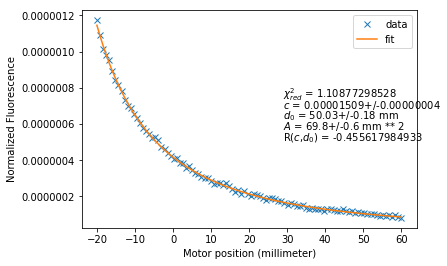

In [6]:
geometry.calibrate(calibrc=calibrc,solidanglecalib=solidangleref,\
                   plot=True,fit=True,fixedactivearea=False)

# Force to real values for testing:
#geometry.zerodistance = units.Quantity(5,"cm")
#detector.activearea = units.Quantity(70,"mm^2")

print("\nCalibrate geometry using {}:".format(caliblines))
print(" Zero-distance: {:~}".format(geometry.zerodistance_rv.to("cm")))
print(" Active area: {:~}".format(detector.activearea_rv.to("mm^2")))

print("\nCurrent distance:")
print " Motor position = {:~}".format(geometry.detectorposition)
print(" Distance: {:~}".format(geometry.distance_rv.to("cm")))

The correlation between the two unknowns $c$ and $d_0$ is low enough to provide estimates of $d_0$ and $A$ with acceptable uncertainty. Known and fitted areal densities should be the same:


Fitted vs. theory (after geometry calibration):
 Mass fractions and areal densities (within one layer):
 La:  24.09 wt%     (expected:  24.13 wt%,     error: -0.15%)
 La:   8.99 ng/mm^2 (expected:   9.00 ng/mm^2, error: -0.15%)
 Mo:   2.35 wt%     (expected:   2.41 wt%,     error: -2.79%)
 Mo:   0.87 ng/mm^2 (expected:   0.90 ng/mm^2, error: -2.79%)
 Pb:  20.59 wt%     (expected:  20.64 wt%,     error: -0.28%)
 Pb:   7.68 ng/mm^2 (expected:   7.70 ng/mm^2, error: -0.28%)
 Si:  60.31 wt%     (expected:  60.06 wt%,     error: 0.42%)
 Si: 414.95 ng/mm^2 (expected: 413.21 ng/mm^2, error: 0.42%)
 Fe:  10.75 wt%     (expected:  10.72 wt%,     error: 0.22%)
 Fe:   4.01 ng/mm^2 (expected:   4.00 ng/mm^2, error: 0.22%)
 Pd:   4.93 wt%     (expected:   5.09 wt%,     error: -3.15%)
 Pd:   1.84 ng/mm^2 (expected:   1.90 ng/mm^2, error: -3.15%)
 Ca:  30.56 wt%     (expected:  30.56 wt%,     error: 0.00%)
 Ca:  11.40 ng/mm^2 (expected:  11.40 ng/mm^2, error: 0.00%)


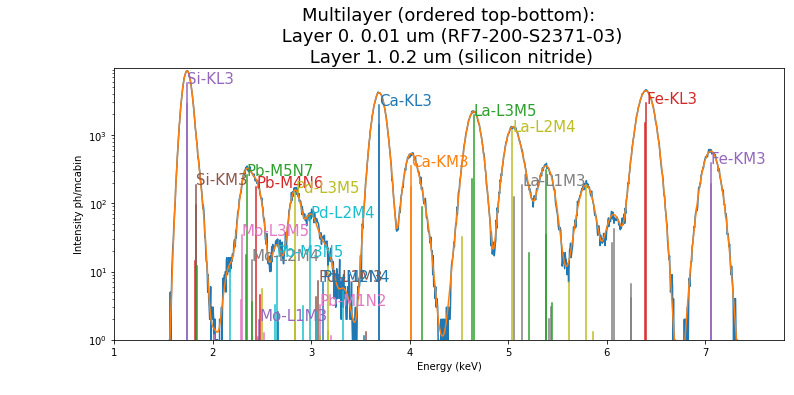

In [7]:
pymcahandle.addtopymca(fresh=False)
fitresult = pymcahandle.fit()
print("\nFitted vs. theory (after geometry calibration):")
printerrors(fitresult,pymcahandle.sample)

plt.figure(figsize=(12,5))
plotfit(fitresult)

spectrum = sample.xrayspectrum(energy,emin=1,emax = energy+0.5,scattering=False,method=method)

matplotlib.rcParams.update({'font.size': 15})
spectrum.plot(histogram=True,decompose=True,fluxtime=pymcahandle.I0,\
              legend=False,forcelines=True)
matplotlib.rcParams.update({'font.size': 14})

plt.show()

Errors originate from least-squares fitting, the thin-film approximation and discrepancies between the algorithm to similate fluorescence and the one used for fitting.